# Define and predict when a tenant is good or bad from the point of view of a landlord

## 1. Load and Import Packages 

In [162]:
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import re
import os
import math
import datetime
from datetime import datetime

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set up File Paths

In [163]:
import_bucket = "data/"

output_bucket = "outputs/"

## 3. Import Data 

In [164]:
contracts = pd.read_csv(import_bucket + "contracts.csv")
contracts.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN
1,1379893624,Buckley,Turnage,1990-01-23,91360.0,2460.0,2013-09-23,NaN
2,1442099134,Mattanel,Lane,1960-04-25,94610.0,2240.0,2015-09-13,NaN
3,1404257907,Joen,Willis,1990-02-12,94109.0,3450.0,2014-07-02,2016-07-01
4,1382396400,Fabiana,Alfaro,1991-09-23,90045.0,2277.0,2013-10-22,NaN


In [165]:
transactions = pd.read_csv(import_bucket + "transactions.csv")
transactions.head()

,contract_id,Payment_date,Amount,payment_method
0,1405033200,2014-12-11,3270.0,BANK_TRANSFER
1,1405033200,2015-01-11,3270.0,BANK_TRANSFER
2,1405033200,2015-02-11,3270.0,BANK_TRANSFER
3,1405033200,2015-03-11,3270.0,BANK_TRANSFER
4,1405033200,2015-04-11,3270.0,BANK_TRANSFER


## 4. Exploratory Data Analysis 

### 1. How many unique contracts are there in total? 

In [166]:
len(pd.concat([transactions['contract_id'], contracts['contract_id']], axis=0).unique())

11579

There are a total of 11,579 unique contracts in total across the contracts and transaction datasets. 

### 2. How many unique contracts are there with a link to transaction information? 

In [167]:
contr_trans_merge = pd.merge(contracts, transactions, how = 'outer', on = "contract_id")
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-09-05,9150.0,DIRECT_DEBIT
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-09-05,3050.0,DIRECT_DEBIT
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-10-06,3050.0,DIRECT_DEBIT
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-11-05,3050.0,DIRECT_DEBIT
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-12-05,3050.0,DIRECT_DEBIT


In [168]:
contr_trans_merge.shape

(273734, 11)

In [169]:
len(contr_trans_merge[(contr_trans_merge['Payment_date'].isna()) & (contr_trans_merge['Amount'].isna()) & (contr_trans_merge['payment_method'].isna())]['contract_id'].unique())

55

In [170]:
len(contr_trans_merge[(contr_trans_merge['name'].isna()) & ((contr_trans_merge['Amount'].notna()) | (contr_trans_merge['payment_method'].notna()) & (contr_trans_merge['payment_method'].notna()))]['contract_id'].unique())

55

There are 55 contract IDs in the contracts data without transaction data and 55 IDs in the transaction data without equivalent contracts IDs. This translates to 1,980 rows of transaction data without equivalent contracts (name, surname, dob, postcode, rent, contract_start, contract_end) data and 55 rows without transactions data (Payment_date, Amount, payment_method). 

### 3. How many unique tenants? 

In [171]:
# Check Missingness
contracts.isnull().sum()

contract_id          0
name                 0
surname              0
dob                  0
postcode             0
rent                 0
contract_start       0
contract_end      9215
dtype: int64

In [172]:
unique_ten = contracts.groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).size()
unique_ten.head()

,name,surname,dob,size
0,A Mateo,Chen,1961-05-08,1
1,A Shaad,Threlkeld,1989-08-24,1
2,A'Aniylah,Bautista,1972-12-27,1
3,A'Dore,Hager,1950-03-27,1
4,A'Dore,Hager,1964-03-18,1


In [173]:
len(unique_ten)

10200

In [174]:
len(unique_ten[unique_ten['size'] > 1])

1254

In [175]:
unique_ten[unique_ten['size'] > 1]['size'].value_counts()

2    1186
3      66
4       2
Name: size, dtype: int64

In [176]:
unique_ten = unique_ten.rename(columns={"size": "num_contracts"})
unique_ten.head()

,name,surname,dob,num_contracts
0,A Mateo,Chen,1961-05-08,1
1,A Shaad,Threlkeld,1989-08-24,1
2,A'Aniylah,Bautista,1972-12-27,1
3,A'Dore,Hager,1950-03-27,1
4,A'Dore,Hager,1964-03-18,1


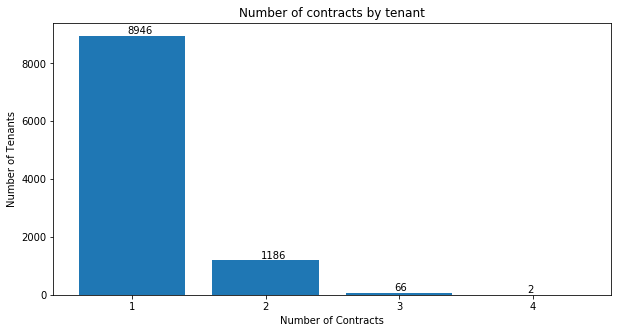

In [177]:
df = unique_ten.groupby(by = ['num_contracts'], dropna = False, as_index = False).size()
df['num_contracts'] = df['num_contracts'].astype('str')

fig1, ax1 = plt.subplots(figsize=(10,5))

barplot = plt.bar(df['num_contracts'], df['size'])
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.2, yval, int(yval), va='bottom') #va: vertical alignment y positional argument
    
plt.title("Number of contracts by tenant")
plt.xlabel('Number of Contracts')
plt.ylabel("Number of Tenants")
plt.savefig(output_bucket + 'contracts_per_tenant.png', bbox_inches='tight')
plt.show()

There are 10,200 unique tenants within the contracts data, 1,254 of which have more than 1 contract. The majority of those with more than 1 contract have 2 contracts (1,186). 66 tenants have 3 contracts while 2 have 4 contracts. No tenants have more than 4 contracts. 

As mentioned previously, there are 55 Ids in the transaction data without equivalent contract IDs in the contract dataset. Given that a single tenant may have multiple contracts, it is not clear whether each contract id corresponds to one tenant or whether one tenant may have multiple contract ids. 

### 6. How many tenants have a total contract history with less than 3, 6, and 12 months of history, and with at least 18 and 24 months of history? 

In [178]:
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-09-05,9150.0,DIRECT_DEBIT
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-09-05,3050.0,DIRECT_DEBIT
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-10-06,3050.0,DIRECT_DEBIT
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-11-05,3050.0,DIRECT_DEBIT
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaN,2017-12-05,3050.0,DIRECT_DEBIT


Based on where there is transaction data present in the data

In [179]:
# Fix Dates 
contr_trans_merge['Payment_date'] = pd.to_datetime(contr_trans_merge['Payment_date'])
contr_trans_merge['contract_start'] = pd.to_datetime(contr_trans_merge['contract_start'])
contr_trans_merge['contract_end'] = pd.to_datetime(contr_trans_merge['contract_end'])

In [180]:
# Create var with contract length 
contr_trans_merge['contract_diff'] = (contr_trans_merge['contract_end'] - contr_trans_merge['contract_start']).dt.days

In [181]:
# Create var with time between each payment 
contr_trans_merge['payment_diff'] = contr_trans_merge.sort_values(['contract_id','Payment_date']).groupby('contract_id')['Payment_date'].diff(1).dt.days

contr_trans_merge.loc[(contr_trans_merge['Payment_date'].notna()) & (contr_trans_merge['payment_diff'].isna()), 'payment_diff'] = 0

In [182]:
unique_ten_contracts = contr_trans_merge.groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).agg({'payment_diff':'sum', 'contract_diff':'mean'})
unique_ten_contracts.head()

,name,surname,dob,contract_id,payment_diff,contract_diff
0,A Mateo,Chen,1961-05-08,1338422679,1065.0,NaN
1,A Shaad,Threlkeld,1989-08-24,1346198062,1068.0,NaN
2,A'Aniylah,Bautista,1972-12-27,1424224498,1003.0,1003.0
3,A'Dore,Hager,1950-03-27,1492996847,244.0,NaN
4,A'Dore,Hager,1964-03-18,1375236673,1065.0,NaN


In [183]:
unique_ten_contracts = unique_ten_contracts.groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).sum()

unique_ten_contracts['total_days'] = unique_ten_contracts.apply(lambda x: x['payment_diff'] if x['contract_diff'] == 0 else x['contract_diff'], axis=1)

unique_ten_contracts.head()

,name,surname,dob,contract_id,payment_diff,contract_diff,total_days
0,A Mateo,Chen,1961-05-08,1338422679,1065.0,0.0,1065.0
1,A Shaad,Threlkeld,1989-08-24,1346198062,1068.0,0.0,1068.0
2,A'Aniylah,Bautista,1972-12-27,1424224498,1003.0,1003.0,1003.0
3,A'Dore,Hager,1950-03-27,1492996847,244.0,0.0,244.0
4,A'Dore,Hager,1964-03-18,1375236673,1065.0,0.0,1065.0


In [184]:
unique_ten_contracts['total_months'] = (unique_ten_contracts['total_days'] * 0.032855).apply(np.ceil).astype(int)
unique_ten_contracts.head()

,name,surname,dob,contract_id,payment_diff,contract_diff,total_days,total_months
0,A Mateo,Chen,1961-05-08,1338422679,1065.0,0.0,1065.0,35
1,A Shaad,Threlkeld,1989-08-24,1346198062,1068.0,0.0,1068.0,36
2,A'Aniylah,Bautista,1972-12-27,1424224498,1003.0,1003.0,1003.0,33
3,A'Dore,Hager,1950-03-27,1492996847,244.0,0.0,244.0,9
4,A'Dore,Hager,1964-03-18,1375236673,1065.0,0.0,1065.0,35


In [185]:
# Drop rows from transactions data missing in claims data as there is no way to know if single or multiple tenants
unique_ten_contracts = unique_ten_contracts[unique_ten_contracts['name'].notna()]

In [186]:
def contract_history(x):
    if ((x > 0) & (x < 3)):
        i = "Less than 3 months"
    elif ((x >= 3) & (x < 6)):
        i = "Less than 6 months"
    elif ((x >= 6) & (x < 12)):
        i = "Less than 12 months"
    elif x == 12:
        i = "12 months"
    elif ((x > 12) & (x < 18)):
        i = "Less than 18 months"
    elif ((x >= 18) & (x < 24)):
        i = "At least 18 months"
    elif (x >= 24):
        i = "At least 24 months"
    else:
        i = "Insufficient information"
    return i 

In [187]:
# Bin history 
unique_ten_contracts['total_history_cat'] = unique_ten_contracts['total_months'].apply(lambda x: contract_history(x))
unique_ten_contracts.head()

,name,surname,dob,contract_id,payment_diff,contract_diff,total_days,total_months,total_history_cat
0,A Mateo,Chen,1961-05-08,1338422679,1065.0,0.0,1065.0,35,At least 24 months
1,A Shaad,Threlkeld,1989-08-24,1346198062,1068.0,0.0,1068.0,36,At least 24 months
2,A'Aniylah,Bautista,1972-12-27,1424224498,1003.0,1003.0,1003.0,33,At least 24 months
3,A'Dore,Hager,1950-03-27,1492996847,244.0,0.0,244.0,9,Less than 12 months
4,A'Dore,Hager,1964-03-18,1375236673,1065.0,0.0,1065.0,35,At least 24 months


In [188]:
unique_ten_contracts['total_history_cat'].value_counts()

At least 24 months          6137
Less than 12 months         1134
At least 18 months          1051
Less than 18 months          743
Less than 6 months           568
Insufficient information     215
12 months                    194
Less than 3 months           158
Name: total_history_cat, dtype: int64

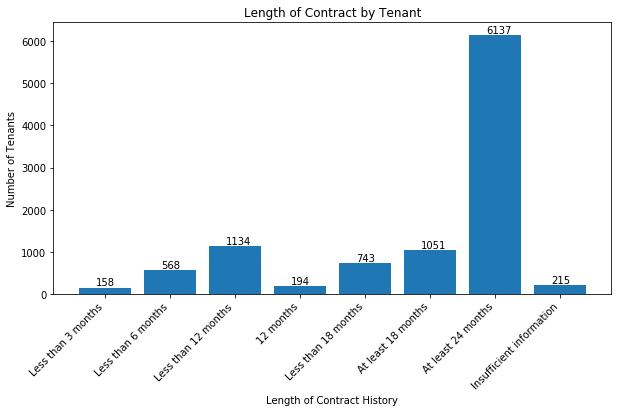

In [189]:
df = unique_ten_contracts['total_history_cat'].value_counts().reindex(["Less than 3 months", "Less than 6 months", "Less than 12 months", "12 months", "Less than 18 months", "At least 18 months", "At least 24 months", "Insufficient information"]).to_frame()
df['index1'] = df.index
df = df.rename(columns = {'total_history_cat':'size','index1':'total_history_cat'})

fig1, ax1 = plt.subplots(figsize=(10,5))

barplot = plt.bar(df['total_history_cat'], df['size'])
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3, yval, int(yval), va='bottom') #va: vertical alignment y positional argument
xlabels = df['total_history_cat'].unique()
ax1.set_xticklabels(xlabels, rotation = 45, ha="right")
plt.title("Length of Contract by Tenant")
plt.xlabel('Length of Contract History')
plt.ylabel("Number of Tenants")
plt.savefig(output_bucket + 'contract_length_per_tenant.png', bbox_inches='tight')
plt.show()

Full contract history (including those who have not finished contract yet)

In [190]:
# Account for end of dataset date

contr_trans_merge['end_of_pay_period'] = contr_trans_merge.apply(lambda x: "2017-12-31" if pd.isnull(x['contract_end']) else x['contract_end'], axis=1)
contr_trans_merge['end_of_pay_period'] = pd.to_datetime(contr_trans_merge['end_of_pay_period'], infer_datetime_format=True)

In [191]:
# Create var with contract length 
contr_trans_merge['time_diff'] = (contr_trans_merge['end_of_pay_period'] - contr_trans_merge['contract_start']).dt.days
contr_trans_merge['time_diff_mos']= (contr_trans_merge['time_diff'] * 0.032855).apply(np.ceil).astype("Int64")
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,DIRECT_DEBIT,NaN,31.0,2017-12-31,117.0,4
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4


In [192]:
contr_trans_merge['Payment_date'].max()

Timestamp('2017-12-31 00:00:00')

In [193]:
unique_ten_contracts_full = contr_trans_merge.groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).agg({'time_diff_mos':'mean'})

unique_ten_contracts_full = unique_ten_contracts_full.groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).sum()
unique_ten_contracts_full.head()

,name,surname,dob,contract_id,time_diff_mos
0,A Mateo,Chen,1961-05-08,1338422679,68.0
1,A Shaad,Threlkeld,1989-08-24,1346198062,65.0
2,A'Aniylah,Bautista,1972-12-27,1424224498,33.0
3,A'Dore,Hager,1950-03-27,1492996847,9.0
4,A'Dore,Hager,1964-03-18,1375236673,54.0


In [194]:
# Bin history 
unique_ten_contracts_full['total_history_cat'] = unique_ten_contracts_full['time_diff_mos'].apply(lambda x: contract_history(x))
unique_ten_contracts_full.head()

,name,surname,dob,contract_id,time_diff_mos,total_history_cat
0,A Mateo,Chen,1961-05-08,1338422679,68.0,At least 24 months
1,A Shaad,Threlkeld,1989-08-24,1346198062,65.0,At least 24 months
2,A'Aniylah,Bautista,1972-12-27,1424224498,33.0,At least 24 months
3,A'Dore,Hager,1950-03-27,1492996847,9.0,Less than 12 months
4,A'Dore,Hager,1964-03-18,1375236673,54.0,At least 24 months


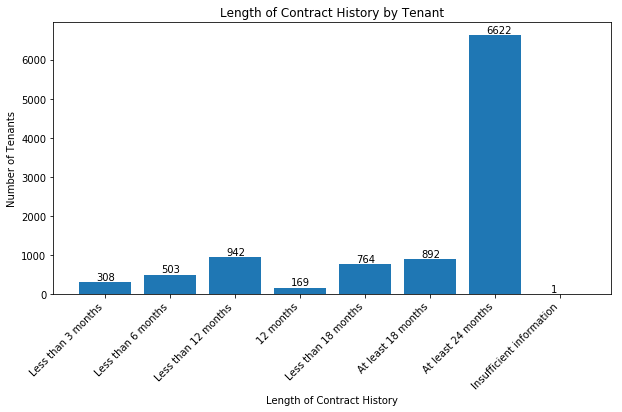

In [195]:
df = unique_ten_contracts_full['total_history_cat'].value_counts().reindex(["Less than 3 months", "Less than 6 months", "Less than 12 months", "12 months", "Less than 18 months", "At least 18 months", "At least 24 months", "Insufficient information"]).to_frame()
df['index1'] = df.index
df = df.rename(columns = {'total_history_cat':'size','index1':'total_history_cat'})

fig1, ax1 = plt.subplots(figsize=(10,5))

barplot = plt.bar(df['total_history_cat'], df['size'])
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3, yval, int(yval), va='bottom') #va: vertical alignment y positional argument
xlabels = df['total_history_cat'].unique()
ax1.set_xticklabels(xlabels, rotation = 45, ha="right")
plt.title("Length of Contract History by Tenant")
plt.xlabel('Length of Contract History')
plt.ylabel("Number of Tenants")
plt.savefig(output_bucket + 'contract_history_per_tenant.png', bbox_inches='tight')
plt.show()

### 7.  How many tenants have used only one payment method? How many more than one? 

In [196]:
contr_trans_merge['payment_method'] = contr_trans_merge['payment_method'].astype('str')
payments_df = contr_trans_merge.groupby(by = ['name', 'surname', 'dob', 'payment_method'], dropna = False, as_index = False).size()

payments_df = payments_df.pivot(columns='payment_method', index=['name','surname','dob'], values='size').reset_index()

payments_df['num_pay_meth'] = payments_df[['BANK_TRANSFER','CASH','DIRECT_DEBIT']].count(axis=1)
payments_df = payments_df.drop(["nan"], axis = 1)

payments_df['BANK_TRANSFER'] = payments_df['BANK_TRANSFER'].fillna(0)
payments_df['CASH'] = payments_df['CASH'].fillna(0)
payments_df['DIRECT_DEBIT'] = payments_df['DIRECT_DEBIT'].fillna(0)

payments_df.head()

payment_method,name,surname,dob,BANK_TRANSFER,CASH,DIRECT_DEBIT,num_pay_meth
0,NaN,NaN,NaN,250.0,42.0,1688.0,3
1,A Mateo,Chen,1961-05-08,36.0,0.0,0.0,1
2,A Shaad,Threlkeld,1989-08-24,0.0,0.0,36.0,1
3,A'Aniylah,Bautista,1972-12-27,34.0,0.0,0.0,1
4,A'Dore,Hager,1950-03-27,0.0,0.0,10.0,1


In [197]:
sum(payments_df['BANK_TRANSFER'])

40039.0

In [198]:
sum(payments_df['DIRECT_DEBIT'])

220372.0

In [199]:
sum(payments_df['CASH'])

13268.0

In [200]:
payments_df = payments_df[(payments_df['name'].notna()) & (payments_df['num_pay_meth'] != 0)]

In [201]:
payments_df['num_pay_meth'].value_counts()

1    9839
2     309
Name: num_pay_meth, dtype: int64

In [202]:
len(payments_df[payments_df['num_pay_meth'] == 0])

0

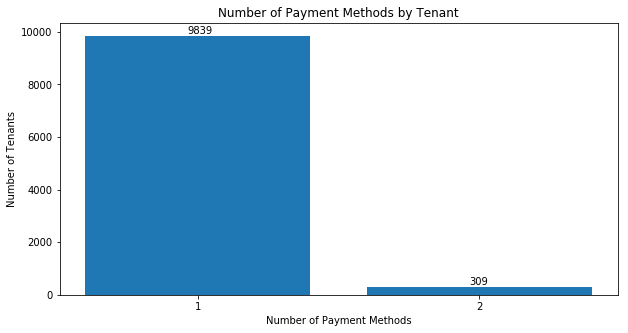

In [203]:
df = payments_df.groupby(by = ['num_pay_meth'], dropna = False, as_index = False).size()
df['num_pay_meth'] = df['num_pay_meth'].astype('str') 
fig1, ax1 = plt.subplots(figsize=(10,5))

barplot = plt.bar(df['num_pay_meth'], df['size'])
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.2, yval, int(yval), va='bottom') #va: vertical alignment y positional argument
    
plt.title("Number of Payment Methods by Tenant")
plt.xlabel('Number of Payment Methods')
plt.ylabel("Number of Tenants")
plt.savefig(output_bucket + 'payment_meth_per_tenant.png', bbox_inches='tight')
plt.show()

### 8. What is the relationship between deposit and rent amount agreed in the contract? 

In [204]:
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,DIRECT_DEBIT,NaN,31.0,2017-12-31,117.0,4
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4


In [205]:
contr_trans_merge['rent_mult'] = contr_trans_merge['Amount']/contr_trans_merge['rent']
contr_trans_merge['rent_mult'] = contr_trans_merge['rent_mult'].round(2) 
contr_trans_merge['rent_mult'].value_counts()

 1.00    221815
 1.05     23300
 1.10      9885
 3.00      6561
 1.20      5895
-3.00      1988
 1.50      1438
 0.00       188
-1.00       117
Name: rent_mult, dtype: int64

In [206]:
first_payment_df = contr_trans_merge.sort_values(['name', 'surname', 'dob','contract_id','contract_start','contract_end','Payment_date']).drop_duplicates(subset=['name', 'surname', 'dob', 'contract_id','contract_start','contract_end'], keep='first')
first_payment_df['rent_mult'].value_counts()

3.0    6561
1.0    4908
Name: rent_mult, dtype: int64

In [207]:
first_payment_df

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult
157775,1338422679,A Mateo,Chen,1961-05-08,94107.0,3370.0,2012-05-31,NaT,2014-12-31,3370.0,BANK_TRANSFER,NaN,0.0,2017-12-31,2040.0,68,1.0
91678,1346198062,A Shaad,Threlkeld,1989-08-24,92808.0,2250.0,2012-08-29,NaT,2014-12-29,2250.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,1950.0,65,1.0
19914,1424224498,A'Aniylah,Bautista,1972-12-27,91790.0,1770.0,2015-02-18,2017-11-17,2015-02-18,5310.0,BANK_TRANSFER,1003.0,0.0,2017-11-17,1003.0,33,3.0
178120,1492996847,A'Dore,Hager,1950-03-27,93940.0,2140.0,2017-04-24,NaT,2017-04-24,6420.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,251.0,9,3.0
146046,1375236673,A'Dore,Hager,1964-03-18,91355.0,2150.0,2013-07-31,NaT,2014-12-31,2150.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,1614.0,54,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272942,1424742911,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2015-02-24,8310.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,NaN,<NA>,NaN
272582,1424827983,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2015-02-25,5580.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,NaN,<NA>,NaN
273374,1424918119,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2015-02-26,9360.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,NaN,<NA>,NaN
273230,1425090344,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2015-02-28,10980.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,NaN,<NA>,NaN


In [208]:
6561+4908

11469

In [209]:
last_payment_df_full = contr_trans_merge[(contr_trans_merge['contract_end'].notna()) & (contr_trans_merge['Payment_date'].notna())].sort_values(['name', 'surname', 'dob','contract_id','contract_start','contract_end','Payment_date']).drop_duplicates(subset=['name', 'surname', 'dob', 'contract_id','contract_start','contract_end'], keep='last')
last_payment_df_full['rent_mult'].value_counts()

-3.0    1988
 0.0     188
-1.0     117
Name: rent_mult, dtype: int64

In [210]:
1988+188+117

2293

In [211]:
check = contr_trans_merge[contr_trans_merge['contract_end'].isna()].sort_values(['name', 'surname', 'dob','contract_id','contract_start','contract_end','Payment_date']).drop_duplicates(subset=['name', 'surname', 'dob', 'contract_id','contract_start','contract_end'], keep='first')
len(check)

9270

In [212]:
9270+2293

11563

In [213]:
df = pd.merge(contr_trans_merge, first_payment_df, on=list(contr_trans_merge.columns), how='left', indicator='pay_type')
contr_trans_merge = pd.merge(df, last_payment_df_full, on=list(contr_trans_merge.columns), how='left', indicator='pay_type_2')

In [214]:
contr_trans_merge[contr_trans_merge['name'] == "Shaan"]

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,pay_type_2
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4,3.0,both,left_only
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4,1.0,left_only,left_only
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,DIRECT_DEBIT,NaN,31.0,2017-12-31,117.0,4,1.0,left_only,left_only
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4,1.0,left_only,left_only
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4,1.0,left_only,left_only


In [215]:
# Deposit pay if the first payment for a contract and after the beginnning of the dataset (i.e. we have full payment history)
# Deposit return if rent multiplier is negative or 0 and the end of the contract is before the end of the dataset (i.e. they have reached the point where the deposit is given back or not)
# Rent if the payment date is not null, if it was first payment for a contract that started before the dataset (i.e. we don't have the deposit info), and if it was not part of a complete contract and had a rent mult of greater than 0 (i.e. not a deposit return)

contr_trans_merge['pay_type'] = contr_trans_merge.apply(lambda x: "deposit pay" if ((x['pay_type'] == "both") & (x['contract_start'] >= pd.to_datetime("2014-12-02"))) else ("deposit return" if ((x['pay_type_2'] == "both") & (x['rent_mult'] <= 0)) else ("rent" if ((pd.notnull(x['Payment_date'])) & (x['pay_type_2'] != "both") & (x['rent_mult'] > 0) | ((pd.notnull(x['Payment_date'])) & (x['pay_type'] != "both") & (x['contract_start'] < pd.to_datetime("2014-12-02")))) else np.nan)), axis=1)
contr_trans_merge = contr_trans_merge.iloc[:, :-1]
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4,3.0,deposit pay
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,DIRECT_DEBIT,NaN,0.0,2017-12-31,117.0,4,1.0,rent
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,DIRECT_DEBIT,NaN,31.0,2017-12-31,117.0,4,1.0,rent
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4,1.0,rent
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,DIRECT_DEBIT,NaN,30.0,2017-12-31,117.0,4,1.0,rent


In [216]:
contr_trans_merge['rent_mult_str'] = contr_trans_merge['rent_mult'].astype('str')
payments_df_ten = contr_trans_merge.groupby(by = ['name', 'surname', 'dob', 'rent_mult_str'], dropna = False, as_index = False).size()
payments_df_ten = payments_df_ten.groupby(['name', 'surname', 'dob'])['rent_mult_str'].apply(lambda x: ','.join(x)).reset_index()
payments_df_ten['dep_count'] = payments_df_ten['rent_mult_str'].apply(lambda x: x.count('3.0'))
payments_df_ten['dep_count'].value_counts()

1    4999
0    3734
2    1467
Name: dep_count, dtype: int64

In [217]:
4908/(6561+4908)

0.42793617577818466

In [218]:
deposit_contract_ids = contr_trans_merge[contr_trans_merge['rent_mult'] <=0].drop_duplicates(subset=['contract_id'])

deposit_contract_ids['deposit_return'] = contr_trans_merge.apply(lambda x: "Not Returned" if x['rent_mult'] == 0 else ("Deposit Partially Returned" if x["rent_mult"] == -1 else "Deposit_Returned"), axis=1)

deposit_contract_ids.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,payment_method,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return
90,1404257907,Joen,Willis,1990-02-12,94109.0,3450.0,2014-07-02,2016-07-01,2016-07-01,-10350.0,DIRECT_DEBIT,730.0,16.0,2016-07-01,730.0,24,-3.0,deposit return,-3.0,Deposit_Returned
235,1392424550,Mi'Onna,Johnson,1959-12-31,93306.0,1600.0,2014-02-15,2016-05-14,2016-05-14,-4800.0,DIRECT_DEBIT,819.0,29.0,2016-05-14,819.0,27,-3.0,deposit return,-3.0,Deposit_Returned
297,1462145638,Madiyan,Moreland,1972-11-30,94122.0,2880.0,2016-05-02,2017-01-01,2017-01-01,-8640.0,DIRECT_DEBIT,244.0,30.0,2017-01-01,244.0,9,-3.0,deposit return,-3.0,Deposit_Returned
308,1412990427,Eduardo,Speckman,1961-03-11,93535.0,1970.0,2014-10-11,2015-10-10,2015-10-10,-5910.0,DIRECT_DEBIT,364.0,29.0,2015-10-10,364.0,12,-3.0,deposit return,-3.0,Deposit_Returned
419,1326674381,Mickie,Ohmstede,1963-01-16,95608.0,1620.0,2012-01-16,2017-05-15,2017-05-15,-4860.0,DIRECT_DEBIT,1946.0,29.0,2017-05-15,1946.0,64,-3.0,deposit return,-3.0,Deposit_Returned


In [219]:
contr_trans_merge = pd.merge(contr_trans_merge, deposit_contract_ids[['contract_id','deposit_return']], how = 'left', on = ['contract_id'])

contr_trans_merge['deposit_return'] = contr_trans_merge['deposit_return'].fillna("Contract Not Ended")

In [220]:
contr_trans_merge['deposit_return'].value_counts()

Contract Not Ended            233802
Deposit_Returned               35098
Not Returned                    2984
Deposit Partially Returned      1850
Name: deposit_return, dtype: int64

In [221]:
contr_trans_merge['deposit_return'] = pd.Categorical(contr_trans_merge['deposit_return'])
contr_trans_merge['deposit_return_num']  = contr_trans_merge['deposit_return'].cat.codes

contr_trans_merge[['deposit_return', 'deposit_return_num']].drop_duplicates()

,deposit_return,deposit_return_num
0,Contract Not Ended,0
71,Deposit_Returned,2
586,Not Returned,3
6103,Deposit Partially Returned,1


The deposit is always 3 times the monthly rent amount or the value of the monthly rent. It is paid along with the first month's rent at the beginning of the lease period and paid back to the tenant at the end of the contract. It appears that 57% of contracts in the data show deposits up front of 3 times the monthly rent while the other approximately 43% of contracts likely did as well but did not have deposits listed in the transactions data due to the fact that the transactions data starts on 12-04-2014. 

### 9. Can you find an example of the transactional history for an evicted tenant, for each possible cause of eviction, and explain the cause of eviction? 

In [222]:
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,...,NaN,0.0,2017-12-31,117.0,4,3.0,deposit pay,3.0,Contract Not Ended,0
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,NaN,0.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,NaN,31.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,NaN,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,NaN,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0


Remove payment data without contracts data 

In [223]:
contr_trans_merge = contr_trans_merge[contr_trans_merge['contract_id'].notna()]

### Option 1: Identify contracts where no deposit was given back or only a partial given back. 

In [224]:
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,...,NaN,0.0,2017-12-31,117.0,4,3.0,deposit pay,3.0,Contract Not Ended,0
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,NaN,0.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,NaN,31.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,NaN,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,NaN,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0


In [225]:
depo_df = contr_trans_merge[['name', 'surname', 'dob', 'contract_id', 'deposit_return_num']].groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).mean()
depo_df['deposit_return_num'].value_counts()

0.0    9286
2.0    1988
3.0     188
1.0     117
Name: deposit_return_num, dtype: int64

In [226]:
check = contr_trans_merge[contr_trans_merge['contract_end'].isna()].groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).mean()

In [227]:
len(check)

9270

1,988 contracts received their deposit back while 188 did not and 117 received partial deposits back. 9,270 are still within their contract and have not reached the end of their contract to be eligible for receiving their deposit back yet. 

In [228]:
rent_only = contr_trans_merge[contr_trans_merge['pay_type'] == "rent"]

In [229]:
rent_only['overfortyfive'] = rent_only['payment_diff'] >= 45
rent_only['overfortyfive'] = rent_only['overfortyfive'].astype(int)

In [230]:
rent_only.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num,overfortyfive
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,0.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,0
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,31.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,0
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,0
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,0
5,1379893624,Buckley,Turnage,1990-01-23,91360.0,2460.0,2013-09-23,NaT,2014-12-23,2460.0,...,0.0,2017-12-31,1560.0,52,1.0,rent,1.0,Contract Not Ended,0,0


All those with finished contracts paid through the end of the contract, so we've only captured those who were not evicted but also damaged the place enough to not receive a security deposit. 

### Option 2: Identify contracts without end dates that do not pay up to the final month of the dataset

In [231]:
no_contract_end = contr_trans_merge[contr_trans_merge['contract_end'].isna()]
no_contract_end.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,...,NaN,0.0,2017-12-31,117.0,4,3.0,deposit pay,3.0,Contract Not Ended,0
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,NaN,0.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,NaN,31.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,NaN,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,NaN,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0


In [232]:
no_contract_end_last = no_contract_end.groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False)['Payment_date'].agg(['max']).rename(columns={'max':'last_any_pay'})
no_contract_end_last = no_contract_end_last.reset_index()

no_contract_end = pd.merge(no_contract_end, no_contract_end_last, how = 'left', on = ['name', 'surname', 'dob', 'contract_id'])
no_contract_end.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num,last_any_pay
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,...,0.0,2017-12-31,117.0,4,3.0,deposit pay,3.0,Contract Not Ended,0,2017-12-05
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,0.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,2017-12-05
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,31.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,2017-12-05
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,2017-12-05
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,30.0,2017-12-31,117.0,4,1.0,rent,1.0,Contract Not Ended,0,2017-12-05


In [233]:
no_contract_end['evicted'] = no_contract_end['last_any_pay'] < "2017-11-01"
no_contract_end['evicted'] = no_contract_end['evicted'].astype(int)

In [234]:
noca_df = no_contract_end[['name', 'surname', 'dob', 'contract_id', 'evicted']].groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).mean()
noca_df['evicted'].value_counts()

0.0    9252
1.0      18
Name: evicted, dtype: int64

Only 18 contracts that did not have end dates made their last payment before November. There is only 1 that last paid before September, 3 before October, and 18 before November. 

In [235]:
no_contract_end['overfortyfive'] = no_contract_end['payment_diff'] >= 45
no_contract_end['overfortyfive'] = no_contract_end['overfortyfive'].astype(int)

In [236]:
no_contract_end_rent_only_con = no_contract_end[(no_contract_end['evicted'] == 1) & (no_contract_end['pay_type'] == "rent")].groupby(by = ['name', 'surname', 'dob', 'contract_id','contract_start', 'contract_end', 'last_any_pay'], dropna = False, as_index = False).agg({'payment_diff':'max', 'overfortyfive':'sum'})

In [237]:
no_contract_end_rent_only_con

,name,surname,dob,contract_id,contract_start,contract_end,last_any_pay,payment_diff,overfortyfive
0,Achilles,Kane,1955-01-07,1368928323,2013-05-19,NaT,2017-10-24,80.0,5
1,Amarre,Alarcon,1975-01-11,1351120343,2012-10-25,NaT,2017-10-26,68.0,3
2,Atara,King,1988-12-31,1458437173,2016-03-20,NaT,2017-10-21,65.0,1
3,Avleen,Cheng,1972-03-25,1466731175,2016-06-24,NaT,2017-10-25,44.0,0
4,Cyril,Hannis,1976-05-03,1461971744,2016-04-30,NaT,2017-10-30,43.0,0
5,Daveah,Melnick,1988-07-31,1419904959,2014-12-30,NaT,2017-10-30,35.0,0
6,Dreah,Arias,1971-11-18,1358989381,2013-01-24,NaT,2017-10-29,63.0,2
7,Evangelista,Hampton,1950-11-13,1376609766,2013-08-16,NaT,2017-10-29,81.0,2
8,Joory,Ibarra,1988-07-21,1450054848,2015-12-14,NaT,2017-10-18,60.0,3
9,Jozlynn,Blanchard,1993-04-18,1364001385,2013-03-23,NaT,2017-10-24,69.0,2


In [238]:
len(no_contract_end_rent_only_con[(no_contract_end_rent_only_con['overfortyfive'] > 1) & (no_contract_end_rent_only_con['payment_diff'] <= 50)])

0

In [239]:
len(no_contract_end_rent_only_con[(no_contract_end_rent_only_con['payment_diff'] > 50) & (no_contract_end_rent_only_con['overfortyfive'] <= 1)])

2

In [240]:
len(no_contract_end_rent_only_con[(no_contract_end_rent_only_con['overfortyfive'] > 1) & (no_contract_end_rent_only_con['payment_diff'] > 50)])

11

13 contracts involved the tenant both paying late by at least 18 days and 11 of those did so on at least 2 occassions. 

### Option 3: Does how much they paid equal how much they should owe? 

Eliminate data with no matching claims and use rent for missing rent data where appropriate. 

In [241]:
contr_trans_merge = contr_trans_merge[(contr_trans_merge['Payment_date'].notnull()) | (contr_trans_merge['Amount'].notnull()) |	((contr_trans_merge['payment_method'].notnull()) & (contr_trans_merge['payment_method'] != "nan"))]

In [242]:
contr_trans_merge['pay_type'].unique()

array(['deposit pay', 'rent', 'deposit return', nan], dtype=object)

In [243]:
contr_trans_merge['Amount'] = contr_trans_merge.apply(lambda x: x['rent'] if ((pd.isnull(x['Amount'])) & ((x['pay_type'] != "deposit pay") | ((x['pay_type'] != "deposit return")))) else x['Amount'], axis=1)

In [244]:
contr_trans_merge[contr_trans_merge['Amount'].isna()]

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num


In [245]:
contr_trans_merge['pay_type'] = contr_trans_merge.apply(lambda x: "rent" if ((pd.isnull(x['rent_mult'])) & ((x['pay_type'] != "deposit pay") | ((x['pay_type'] != "deposit return")))) else x['pay_type'], axis=1)

contr_trans_merge['rent_mult'] = contr_trans_merge['Amount']/contr_trans_merge['rent']
contr_trans_merge['rent_mult'] = contr_trans_merge['rent_mult'].round(2) 

In [246]:
contr_trans_merge[(contr_trans_merge['name'].notna())&(contr_trans_merge['Payment_date'].isna())&(contr_trans_merge['Amount'].isna())]

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,contract_diff,payment_diff,end_of_pay_period,time_diff,time_diff_mos,rent_mult,pay_type,rent_mult_str,deposit_return,deposit_return_num


Calculate how much rent has been paid per contract and mean rent_mult for fees

In [247]:
rent_agg = contr_trans_merge[contr_trans_merge['pay_type'] == "rent"][['name', 'surname', 'dob', 'contract_id', 'Amount', 'rent_mult', 'Payment_date']].groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).agg({'Amount':['sum','size'],'rent_mult':'mean', 'Payment_date':'size'})
rent_agg.columns = [' '.join(col).strip() for col in rent_agg.columns.values]

rent_agg = rent_agg.rename(columns={'Amount sum': 'full_rent_pay', 'Amount size': 'full_rent_months', 'rent_mult mean':'full_fee_perc'}) 
rent_agg['full_fee_perc'] = rent_agg['full_fee_perc'] - 1

rent_agg['full_rent_months'] = rent_agg.apply(lambda x: x['full_rent_months'] if x['full_rent_months'] >= x['Payment_date size'] else x['Payment_date size'], axis=1)
rent_agg = rent_agg.drop(columns=['Payment_date size'])

rent_agg.head()

,name,surname,dob,contract_id,full_rent_pay,full_rent_months,full_fee_perc
0,A Mateo,Chen,1961-05-08,1338422679,121825.5,36,0.004167
1,A Shaad,Threlkeld,1989-08-24,1346198062,82687.5,36,0.020833
2,A'Aniylah,Bautista,1972-12-27,1424224498,61419.0,32,0.084375
3,A'Dore,Hager,1950-03-27,1492996847,19474.0,9,0.011111
4,A'Dore,Hager,1964-03-18,1375236673,78905.0,36,0.019444


In [248]:
contr_trans_merge['Payment_date'].max()

Timestamp('2017-12-31 00:00:00')

Account for start of dataset date

In [249]:
contr_trans_merge['extra_start_pay_mos'] = (contr_trans_merge['Payment_date'].min() - contr_trans_merge['contract_start']).dt.days

In [250]:
contr_trans_merge['extra_start_pay_mos'] = (contr_trans_merge['extra_start_pay_mos'] * 0.032855).apply(np.ceil).astype("Int64")

In [251]:
contr_trans_merge['extra_start_pay_mos'] = contr_trans_merge.apply(lambda x: x['extra_start_pay_mos'] if ((x['extra_start_pay_mos'] >= 0) & (pd.notnull(x['extra_start_pay_mos']))) else (0 if ((x['extra_start_pay_mos'] < 0) & (pd.notnull(x['extra_start_pay_mos']))) else np.nan), axis=1)

In [252]:
def compare_ds(x,y):
    try:
        r = int(x.strftime("%m/%d/%Y, %H:%M:%S").split("/")[1])
        p = int(y.strftime("%m/%d/%Y, %H:%M:%S").split("/")[1])
        if r < p:
            t = True
        else:
            t = False
    except: 
        t = False
    return t

Account for fact that last month appears to not need rent payment if the last date is less than the contract start date. For example, if a contract started 2013-7-28 and the contract ends on 2017-1-27, there is no rent needed to be payed for January because it ends before 1/28.

In [253]:
contr_trans_merge['time_diff_mos'] = contr_trans_merge.apply(lambda x: x['time_diff_mos'] - 1 if compare_ds(x['end_of_pay_period'],x['contract_start']) == True  else x['time_diff_mos'], axis=1)

In [254]:
contr_trans_merge['expected_rent'] = contr_trans_merge['time_diff_mos'] * contr_trans_merge['rent']

In [255]:
contr_trans_merge = pd.merge(contr_trans_merge, rent_agg, how = 'left', on = ['name', 'surname', 'dob', 'contract_id'])

Account for late fees

In [256]:
contr_trans_merge['total_fees'] = contr_trans_merge['full_rent_pay'] * contr_trans_merge['full_fee_perc']

In [257]:
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,pay_type,rent_mult_str,deposit_return,deposit_return_num,extra_start_pay_mos,expected_rent,full_rent_pay,full_rent_months,full_fee_perc,total_fees
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,...,deposit pay,3.0,Contract Not Ended,0,0.0,12200.0,12200.0,4,0.0,0.0
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,rent,1.0,Contract Not Ended,0,0.0,12200.0,12200.0,4,0.0,0.0
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,rent,1.0,Contract Not Ended,0,0.0,12200.0,12200.0,4,0.0,0.0
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,rent,1.0,Contract Not Ended,0,0.0,12200.0,12200.0,4,0.0,0.0
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,rent,1.0,Contract Not Ended,0,0.0,12200.0,12200.0,4,0.0,0.0


In [258]:
contr_trans_merge['rent_gap'] = contr_trans_merge['expected_rent'] - (contr_trans_merge['full_rent_pay'] + (contr_trans_merge['rent'] * contr_trans_merge['extra_start_pay_mos']) - contr_trans_merge['total_fees'])

Account for fact that some may be a little late on paying the rent  before the end of the dataset (due on 12/28 but likely won't pay until 1/2 for example)

In [259]:
contr_trans_merge['rent_gap_cushion'] = contr_trans_merge['rent_gap'] - contr_trans_merge['rent']

In [260]:
contr_trans_merge['calc_total_payments'] = contr_trans_merge['extra_start_pay_mos'] + contr_trans_merge['full_rent_months']

In [261]:
contr_trans_merge['calc_total_payments_cushion'] =  contr_trans_merge['calc_total_payments']

In [262]:
contr_trans_merge['total_payments_cushion_gap'] = contr_trans_merge['time_diff_mos'] - contr_trans_merge['calc_total_payments_cushion']

In [263]:
questionable = contr_trans_merge[((contr_trans_merge['rent'].notna()) & (contr_trans_merge['Amount'].notna())) & (contr_trans_merge['rent_gap_cushion'] > contr_trans_merge['rent']) & (contr_trans_merge['time_diff_mos'] > contr_trans_merge['calc_total_payments_cushion'])]
questionable = questionable[questionable['deposit_return'] != "Deposit_Returned"]
questionable 

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,expected_rent,full_rent_pay,full_rent_months,full_fee_perc,total_fees,rent_gap,rent_gap_cushion,calc_total_payments,calc_total_payments_cushion,total_payments_cushion_gap
630,1345247409,Aibhin,Mccauley,1959-08-19,90272.0,2980.0,2012-08-18,NaT,2014-12-18,2980.0,...,193700.0,118008.0,35,0.131429,15509.622857,7761.622857,4781.622857,63.0,63.0,2.0
631,1345247409,Aibhin,Mccauley,1959-08-19,90272.0,2980.0,2012-08-18,NaT,2015-01-18,2980.0,...,193700.0,118008.0,35,0.131429,15509.622857,7761.622857,4781.622857,63.0,63.0,2.0
632,1345247409,Aibhin,Mccauley,1959-08-19,90272.0,2980.0,2012-08-18,NaT,2015-02-18,2980.0,...,193700.0,118008.0,35,0.131429,15509.622857,7761.622857,4781.622857,63.0,63.0,2.0
633,1345247409,Aibhin,Mccauley,1959-08-19,90272.0,2980.0,2012-08-18,NaT,2015-03-18,2980.0,...,193700.0,118008.0,35,0.131429,15509.622857,7761.622857,4781.622857,63.0,63.0,2.0
634,1345247409,Aibhin,Mccauley,1959-08-19,90272.0,2980.0,2012-08-18,NaT,2015-05-02,3278.0,...,193700.0,118008.0,35,0.131429,15509.622857,7761.622857,4781.622857,63.0,63.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265995,1368928323,Achilles,Kane,1955-01-07,91364.0,2530.0,2013-05-19,NaT,2017-06-21,2530.0,...,141680.0,97531.5,35,0.101429,9892.480714,5970.980714,3440.980714,54.0,54.0,2.0
265996,1368928323,Achilles,Kane,1955-01-07,91364.0,2530.0,2013-05-19,NaT,2017-07-31,2783.0,...,141680.0,97531.5,35,0.101429,9892.480714,5970.980714,3440.980714,54.0,54.0,2.0
265997,1368928323,Achilles,Kane,1955-01-07,91364.0,2530.0,2013-05-19,NaT,2017-08-23,2656.5,...,141680.0,97531.5,35,0.101429,9892.480714,5970.980714,3440.980714,54.0,54.0,2.0
265998,1368928323,Achilles,Kane,1955-01-07,91364.0,2530.0,2013-05-19,NaT,2017-09-19,2530.0,...,141680.0,97531.5,35,0.101429,9892.480714,5970.980714,3440.980714,54.0,54.0,2.0


In [264]:
questionable_con = questionable.groupby(by = ['name', 'surname', 'dob', 'contract_id', 'contract_start', 'contract_end', 'deposit_return_num', 'total_payments_cushion_gap'], dropna = False, as_index = False).agg({'contract_id':'size', 'deposit_return_num':'mean','total_payments_cushion_gap':'mean'})


questionable_con = pd.merge(questionable_con, contr_trans_merge[['deposit_return','deposit_return_num']].drop_duplicates()
, how = 'left', on = ['deposit_return_num'])

questionable_con

,name,surname,dob,contract_start,contract_end,contract_id,deposit_return_num,total_payments_cushion_gap,deposit_return
0,Aamani,Gonzalez,1961-05-21,2014-10-27,NaT,35,0.0,2.0,Contract Not Ended
1,Achilles,Kane,1955-01-07,2013-05-19,NaT,35,0.0,2.0,Contract Not Ended
2,Aibhin,Mccauley,1959-08-19,2012-08-18,NaT,35,0.0,2.0,Contract Not Ended
3,Amarre,Alarcon,1975-01-11,2012-10-25,NaT,35,0.0,2.0,Contract Not Ended
4,Atara,King,1988-12-31,2016-03-20,NaT,21,0.0,2.0,Contract Not Ended
5,Avleen,Cheng,1972-03-25,2016-06-24,NaT,18,0.0,2.0,Contract Not Ended
6,Cyril,Hannis,1976-05-03,2016-04-30,NaT,20,0.0,2.0,Contract Not Ended
7,Daveah,Melnick,1988-07-31,2014-12-30,NaT,36,0.0,2.0,Contract Not Ended
8,Davi'Yon,Payne,1986-02-27,2013-04-23,NaT,34,0.0,3.0,Contract Not Ended
9,Diyor,Morris,1951-05-29,2015-07-01,NaT,30,0.0,2.0,Contract Not Ended


In [265]:
len(questionable_con)

32

Get rid of transactions data without tenants

In [266]:
contr_trans_merge = contr_trans_merge[contr_trans_merge['name'].notna()]

In [267]:
contr_trans_merge.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,Payment_date,Amount,...,expected_rent,full_rent_pay,full_rent_months,full_fee_perc,total_fees,rent_gap,rent_gap_cushion,calc_total_payments,calc_total_payments_cushion,total_payments_cushion_gap
0,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,9150.0,...,12200.0,12200.0,4,0.0,0.0,0.0,-3050.0,4.0,4.0,0.0
1,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-09-05,3050.0,...,12200.0,12200.0,4,0.0,0.0,0.0,-3050.0,4.0,4.0,0.0
2,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-10-06,3050.0,...,12200.0,12200.0,4,0.0,0.0,0.0,-3050.0,4.0,4.0,0.0
3,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-11-05,3050.0,...,12200.0,12200.0,4,0.0,0.0,0.0,-3050.0,4.0,4.0,0.0
4,1504571043,Shaan,Gonzalez,1951-07-26,94123.0,3050.0,2017-09-05,NaT,2017-12-05,3050.0,...,12200.0,12200.0,4,0.0,0.0,0.0,-3050.0,4.0,4.0,0.0


Why do tenants pay above rent price for particular months? What are the bounds of late charges?

In [268]:
rent_late_fees = contr_trans_merge[(contr_trans_merge['pay_type'] == "rent") & (contr_trans_merge['Payment_date'].notnull()) & (contr_trans_merge['rent_mult_str'] != "nan")].groupby(by = ['rent_mult_str'], dropna = False, as_index = False).agg({'payment_diff':['min', 'mean','max', 'size']})

rent_late_fees.columns = [' '.join(col).strip() for col in rent_late_fees.columns.values]

rent_late_fees

,rent_mult_str,payment_diff min,payment_diff mean,payment_diff max,payment_diff size
0,1.0,0.0,28.389266,33.0,221815
1,1.05,0.0,30.315193,38.0,23300
2,1.1,0.0,33.557613,45.0,9885
3,1.2,0.0,40.200848,61.0,5895
4,1.5,16.0,61.607093,91.0,1438


In [269]:
contr_trans_merge['rent_mult_str_num'] = contr_trans_merge['rent_mult_str'].astype('float')

It appears that landlords typically charged the normal rent up to 33 days between rent payments and added on 5% increments.

In [270]:
rent_late_fees_con = contr_trans_merge[(contr_trans_merge['rent_mult_str_num'].notna()) & (contr_trans_merge['rent_mult_str_num'] > 1) & (contr_trans_merge['pay_type'] == "rent")].groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).agg({'rent_mult_str_num':['size','mean','max']})
rent_late_fees_con.columns = [' '.join(col).strip() for col in rent_late_fees_con.columns.values]

rent_late_fees_con = rent_late_fees_con.rename(columns={'rent_mult_str_num size': 'late_payments_num', 'rent_mult_str_num mean': 'avg_late_perc', 'rent_mult_str_num max':'max_late'}) 

rent_late_fees_con.head()

,name,surname,dob,late_payments_num,avg_late_perc,max_late
0,A Mateo,Chen,1961-05-08,3,1.050000,1.05
1,A Shaad,Threlkeld,1989-08-24,13,1.057692,1.10
2,A'Aniylah,Bautista,1972-12-27,23,1.117391,1.50
3,A'Dore,Hager,1950-03-27,2,1.050000,1.05
4,A'Dore,Hager,1964-03-18,9,1.077778,1.20


In [271]:
On_time_rent = contr_trans_merge[(contr_trans_merge['rent_mult_str_num'].notna()) & (contr_trans_merge['rent_mult_str_num'] == 1) & (contr_trans_merge['pay_type'] == "rent")].groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).agg({'rent_mult_str_num':'size'})

On_time_rent = On_time_rent.rename(columns={'rent_mult_str_num': 'on_time_rent_num'}) 

On_time_rent.head()

,name,surname,dob,on_time_rent_num
0,A Mateo,Chen,1961-05-08,33
1,A Shaad,Threlkeld,1989-08-24,23
2,A'Aniylah,Bautista,1972-12-27,7
3,A'Dore,Hager,1950-03-27,7
4,A'Dore,Hager,1964-03-18,27


In [272]:
contr_trans_merge['pay_type'].value_counts()

rent              262845
deposit pay         6561
deposit return      2293
Name: pay_type, dtype: int64

In [273]:
Deposit_amount = contr_trans_merge[(contr_trans_merge['pay_type'] == "deposit pay")].groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).agg({'rent_mult':'mean'})

Deposit_amount.head()

,name,surname,dob,rent_mult
0,A'Aniylah,Bautista,1972-12-27,3.0
1,A'Dore,Hager,1950-03-27,3.0
2,A'Isha,Mccorkle,1964-06-15,3.0
3,A'Jeon,Acosta,1957-02-08,3.0
4,A'Jeon,Troop,1962-04-29,3.0


In [274]:
Deposit_amount['rent_mult'].value_counts()

3.0    6058
Name: rent_mult, dtype: int64

In [275]:
rent_only_time_between = contr_trans_merge[contr_trans_merge['pay_type'] == "rent"]
rent_only_time_between['payment_diff'] = rent_only_time_between.sort_values(['contract_id','Payment_date']).groupby('contract_id')['Payment_date'].diff(1).dt.days

rent_only_time_between.loc[(rent_only_time_between['Payment_date'].notna()) & (rent_only_time_between['payment_diff'].isna()), 'payment_diff'] = 0

rent_only_time_between = rent_only_time_between.groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).agg({'payment_diff':['size', 'min', 'median','max']})

rent_only_time_between.columns = [' '.join(col).strip() for col in rent_only_time_between.columns.values]

rent_only_time_between = rent_only_time_between.rename(columns={'payment_diff size': 'num_rent_pay', 'payment_diff min': 'fastest_between_rent_pay', 'payment_diff median':'median_between_rent_pay', 'payment_diff max':'slowest_between_rent_pay'}) 

rent_only_time_between.head()

,name,surname,dob,num_rent_pay,fastest_between_rent_pay,median_between_rent_pay,slowest_between_rent_pay
0,A Mateo,Chen,1961-05-08,36,0.0,31.0,34.0
1,A Shaad,Threlkeld,1989-08-24,36,0.0,30.0,40.0
2,A'Aniylah,Bautista,1972-12-27,32,0.0,29.0,63.0
3,A'Dore,Hager,1950-03-27,9,0.0,31.0,38.0
4,A'Dore,Hager,1964-03-18,36,0.0,30.5,43.0


In [276]:
one_zip = contr_trans_merge[['name','surname','dob','postcode']].drop_duplicates(subset=['name','surname','dob'])

In [277]:
payment_data = contr_trans_merge[contr_trans_merge['payment_method'].notna()].groupby(by = ['name', 'surname', 'dob'], dropna = False, as_index = False).size()
payment_data = payment_data.rename(columns={'size':'all_pay_total'}) 
payment_data.head()

,name,surname,dob,all_pay_total
0,A Mateo,Chen,1961-05-08,36
1,A Shaad,Threlkeld,1989-08-24,36
2,A'Aniylah,Bautista,1972-12-27,34
3,A'Dore,Hager,1950-03-27,10
4,A'Dore,Hager,1964-03-18,36


In [278]:
contract_diff_no_na = contr_trans_merge[contr_trans_merge['contract_diff'].notna()]

In [279]:
contr_trans_merge['age_contract_start'] = (contr_trans_merge['contract_start'] - pd.to_datetime(contr_trans_merge['dob'])).dt.days
contr_trans_merge['age_contract_start']  = (contr_trans_merge['age_contract_start'] /365).apply(np.ceil).astype(int)

In [280]:
contr_trans_merge['rent_gap_cushion'] =  contr_trans_merge['rent_gap_cushion'].apply(lambda x: 0 if x<0 else x)

In [281]:
pd.set_option('display.max_columns', None)

contr_trans_merge_con = contr_trans_merge.groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).agg({'rent':'mean', 'time_diff':'mean', 'deposit_return_num':'mean', 'rent_gap_cushion':'mean', 'total_payments_cushion_gap':'mean','age_contract_start':'min'})

contr_trans_merge_ten = contr_trans_merge_con.groupby(by = ['name', 'surname', 'dob', 'contract_id'], dropna = False, as_index = False).agg({'rent':'mean', 'time_diff':['sum','mean'], 'deposit_return_num':'mean', 'rent_gap_cushion':'sum', 'total_payments_cushion_gap':'sum','age_contract_start':'min', 'contract_id':'size'})

contr_trans_merge_ten.columns = [' '.join(col).strip() for col in contr_trans_merge_ten.columns.values]

contr_trans_merge_ten = contr_trans_merge_ten.rename(columns={'rent mean': 'avg_rent', 'time_diff sum': 'total_contract_length', 'time_diff mean':'avg_contract_length', 'deposit_return_num mean':'deposit_return_num', 'rent_gap_cushion mean':'avg_rent_gap', 'rent_gap_cushion sum':'total_rent_gap', 'total_payments_cushion_gap sum':'total_total_payments_gap','age_contract_start min':'age_contract_start', 'contract_id size': 'num_contracts'}) 

contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, contr_trans_merge[['deposit_return','deposit_return_num']].drop_duplicates()
, how = 'left', on = ['deposit_return_num'])

contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, rent_late_fees_con
, how = 'left', on = ['name','surname','dob'])

contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, On_time_rent
, how = 'left', on = ['name','surname','dob'])


contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, rent_only_time_between
, how = 'left', on = ['name','surname','dob'])

contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, payments_df[['name','surname','dob', 'DIRECT_DEBIT', 'CASH', 'BANK_TRANSFER', 'num_pay_meth']]
, how = 'left', on = ['name','surname','dob'])

contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, one_zip
, how = 'left', on = ['name','surname','dob'])

contr_trans_merge_ten = pd.merge(contr_trans_merge_ten, payment_data
, how = 'left', on = ['name','surname','dob'])

contr_trans_merge_ten['deposit_scale'] = contr_trans_merge_ten.apply(lambda x: 0 if ((x['deposit_return'] == "Contract Not Ended") | (x['deposit_return'] == "Deposit_Returned")) else (0.5 if x["deposit_return"] == "Deposit Partially Returned" else 1), axis = 1)

contr_trans_merge_ten = pd.get_dummies(contr_trans_merge_ten,columns=['deposit_return'])

contr_trans_merge_ten = contr_trans_merge_ten.rename(columns={'deposit_return_Contract Not Ended': 'contract_not_ended'}) 

contr_trans_merge_ten = contr_trans_merge_ten.drop(['deposit_return_Deposit Partially Returned', 'deposit_return_Deposit_Returned', 'deposit_return_Not Returned'], axis=1)

contr_trans_merge_ten.head()

,name,surname,dob,avg_rent,total_contract_length,avg_contract_length,deposit_return_num,total_rent_gap,total_total_payments_gap,age_contract_start,num_contracts,late_payments_num,avg_late_perc,max_late,on_time_rent_num,num_rent_pay,fastest_between_rent_pay,median_between_rent_pay,slowest_between_rent_pay,DIRECT_DEBIT,CASH,BANK_TRANSFER,num_pay_meth,postcode,all_pay_total,deposit_scale,contract_not_ended
0,A Mateo,Chen,1961-05-08,3370.0,2040.0,2040.0,0.0,2.106250,1.0,52,1,3.0,1.050000,1.05,33,36,0.0,31.0,34.0,0.0,0.0,36.0,1,94107.0,36,0.0,1
1,A Shaad,Threlkeld,1989-08-24,2250.0,1950.0,1950.0,0.0,35.156250,1.0,24,1,13.0,1.057692,1.10,23,36,0.0,30.0,40.0,36.0,0.0,0.0,1,92808.0,36,0.0,1
2,A'Aniylah,Bautista,1972-12-27,1770.0,1003.0,1003.0,3.0,0.000000,0.0,43,1,23.0,1.117391,1.50,7,32,0.0,29.0,63.0,0.0,0.0,34.0,1,91790.0,34,1.0,0
3,A'Dore,Hager,1950-03-27,2140.0,251.0,251.0,0.0,0.000000,0.0,68,1,2.0,1.050000,1.05,7,9,0.0,31.0,38.0,10.0,0.0,0.0,1,93940.0,10,0.0,1
4,A'Dore,Hager,1964-03-18,2150.0,1614.0,1614.0,0.0,29.263889,1.0,50,1,9.0,1.077778,1.20,27,36,0.0,30.5,43.0,36.0,0.0,0.0,1,91355.0,36,0.0,1


In [306]:
questionable_con['poss_evict'] = 1
df = pd.merge(contr_trans_merge_ten, questionable_con[['name','surname','dob', 'poss_evict']], on=['name','surname','dob'], how='left')
df = df[df['poss_evict'] == 1]
df.head()

,name,surname,dob,avg_rent,total_contract_length,avg_contract_length,deposit_return_num,total_rent_gap,total_total_payments_gap,age_contract_start,num_contracts,late_payments_num,avg_late_perc,max_late,on_time_rent_num,num_rent_pay,fastest_between_rent_pay,median_between_rent_pay,slowest_between_rent_pay,DIRECT_DEBIT,CASH,BANK_TRANSFER,num_pay_meth,postcode,all_pay_total,deposit_scale,contract_not_ended,poss_evict
83,Aamani,Gonzalez,1961-05-21,1430.0,1161.0,1161.0,0.0,1577.494286,2.0,54,1,24.0,1.079167,1.2,11,35,0.0,30.0,58.0,35.0,0.0,0.0,1,90038.0,35,0.0,1,1.0
233,Achilles,Kane,1955-01-07,2530.0,1687.0,1687.0,0.0,3440.980714,2.0,59,1,26.0,1.136538,1.5,9,35,0.0,30.0,80.0,34.0,1.0,0.0,2,91364.0,35,0.0,1,1.0
392,Aibhin,Mccauley,1959-08-19,2980.0,1961.0,1961.0,0.0,4781.622857,2.0,54,1,29.0,1.158621,1.5,6,35,0.0,29.0,70.0,35.0,0.0,0.0,1,90272.0,35,0.0,1,1.0
708,Amarre,Alarcon,1975-01-11,3260.0,1893.0,1893.0,0.0,3429.752857,2.0,38,1,10.0,1.135000,1.5,25,35,0.0,31.0,68.0,34.0,1.0,0.0,2,92075.0,35,0.0,1,1.0
1225,Atara,King,1988-12-31,1800.0,651.0,651.0,0.0,1827.225000,2.0,28,1,2.0,1.275000,1.5,18,20,0.0,30.5,65.0,20.0,1.0,0.0,2,91941.0,21,0.0,1,1.0


In [307]:
df['late_payments_num'] = df['late_payments_num'].apply(lambda x: x>3 if x else 0)
df['slowest_between_rent_pay'] = df['slowest_between_rent_pay'].apply(lambda x: x>61 if x else 0)
df['super_late'] = df['max_late'].apply(lambda x: x == 1.5 if x else 0)
evict_types = df[['poss_evict', 'late_payments_num', 'slowest_between_rent_pay', 'super_late']].groupby(by = ['poss_evict'], dropna = False, as_index = False).sum()
evict_types

,poss_evict,late_payments_num,slowest_between_rent_pay,super_late
0,1.0,31,21,24


In [308]:
evict_late = df.groupby(by = ['max_late'], dropna = False, as_index = False).size()
evict_late

,max_late,size
0,1.05,1
1,1.20,10
2,1.50,24


## 5. Label Creation

Normalize and Create Label

In [309]:
contr_trans_merge_ten['total_rent_gap_norm'] = (contr_trans_merge_ten['total_rent_gap']-contr_trans_merge_ten['total_rent_gap'].min())/(contr_trans_merge_ten['total_rent_gap'].max()-contr_trans_merge_ten['total_rent_gap'].min())

contr_trans_merge_ten['total_total_payments_gap'] = contr_trans_merge_ten['total_total_payments_gap'].apply(lambda x: 0 if x<0 else x)

contr_trans_merge_ten['total_total_payments_gap_norm'] = (contr_trans_merge_ten['total_total_payments_gap']-contr_trans_merge_ten['total_total_payments_gap'].min())/(contr_trans_merge_ten['total_total_payments_gap'].max()-contr_trans_merge_ten['total_total_payments_gap'].min())

contr_trans_merge_ten['late_payments_num'] = contr_trans_merge_ten['late_payments_num'].fillna(0)

contr_trans_merge_ten['late_payments_perc'] = contr_trans_merge_ten['late_payments_num']/contr_trans_merge_ten['num_rent_pay']

contr_trans_merge_ten['late_payments_perc_norm'] = (contr_trans_merge_ten['late_payments_perc']-contr_trans_merge_ten['late_payments_perc'].min())/(contr_trans_merge_ten['late_payments_perc'].max()-contr_trans_merge_ten['late_payments_perc'].min())

contr_trans_merge_ten['avg_late_perc'] = contr_trans_merge_ten['avg_late_perc']-1
contr_trans_merge_ten['avg_late_perc'] = contr_trans_merge_ten['avg_late_perc'].fillna(0)

contr_trans_merge_ten['avg_late_perc_norm'] = (contr_trans_merge_ten['avg_late_perc']-contr_trans_merge_ten['avg_late_perc'].min())/(contr_trans_merge_ten['avg_late_perc'].max()-contr_trans_merge_ten['avg_late_perc'].min())

contr_trans_merge_ten['max_late'] = contr_trans_merge_ten['max_late']-1
contr_trans_merge_ten['max_late'] =contr_trans_merge_ten['max_late'].fillna(0)

contr_trans_merge_ten['max_late_norm'] = (contr_trans_merge_ten['max_late']-contr_trans_merge_ten['max_late'].min())/(contr_trans_merge_ten['max_late'].max()-contr_trans_merge_ten['max_late'].min())

contr_trans_merge_ten['slowest_between_rent_pay_norm'] = (contr_trans_merge_ten['slowest_between_rent_pay']-contr_trans_merge_ten['slowest_between_rent_pay'].min())/(contr_trans_merge_ten['slowest_between_rent_pay'].max()-contr_trans_merge_ten['slowest_between_rent_pay'].min())

contr_trans_merge_ten['DIRECT_DEBIT'] = contr_trans_merge_ten['DIRECT_DEBIT']/contr_trans_merge_ten['all_pay_total']
contr_trans_merge_ten['CASH'] = contr_trans_merge_ten['CASH']/contr_trans_merge_ten['all_pay_total']
contr_trans_merge_ten['BANK_TRANSFER'] = contr_trans_merge_ten['BANK_TRANSFER']/contr_trans_merge_ten['all_pay_total']

contr_trans_merge_ten.head()

,name,surname,dob,avg_rent,total_contract_length,avg_contract_length,deposit_return_num,total_rent_gap,total_total_payments_gap,age_contract_start,num_contracts,late_payments_num,avg_late_perc,max_late,on_time_rent_num,num_rent_pay,fastest_between_rent_pay,median_between_rent_pay,slowest_between_rent_pay,DIRECT_DEBIT,CASH,BANK_TRANSFER,num_pay_meth,postcode,all_pay_total,deposit_scale,contract_not_ended,total_rent_gap_norm,total_total_payments_gap_norm,late_payments_perc,late_payments_perc_norm,avg_late_perc_norm,max_late_norm,slowest_between_rent_pay_norm
0,A Mateo,Chen,1961-05-08,3370.0,2040.0,2040.0,0.0,2.106250,1.0,52,1,3.0,0.050000,0.05,33,36,0.0,31.0,34.0,0.0,0.0,1.0,1,94107.0,36,0.0,1,0.000316,0.25,0.083333,0.088542,0.100000,0.1,0.369565
1,A Shaad,Threlkeld,1989-08-24,2250.0,1950.0,1950.0,0.0,35.156250,1.0,24,1,13.0,0.057692,0.10,23,36,0.0,30.0,40.0,1.0,0.0,0.0,1,92808.0,36,0.0,1,0.005279,0.25,0.361111,0.383681,0.115385,0.2,0.434783
2,A'Aniylah,Bautista,1972-12-27,1770.0,1003.0,1003.0,3.0,0.000000,0.0,43,1,23.0,0.117391,0.50,7,32,0.0,29.0,63.0,0.0,0.0,1.0,1,91790.0,34,1.0,0,0.000000,0.00,0.718750,0.763672,0.234783,1.0,0.684783
3,A'Dore,Hager,1950-03-27,2140.0,251.0,251.0,0.0,0.000000,0.0,68,1,2.0,0.050000,0.05,7,9,0.0,31.0,38.0,1.0,0.0,0.0,1,93940.0,10,0.0,1,0.000000,0.00,0.222222,0.236111,0.100000,0.1,0.413043
4,A'Dore,Hager,1964-03-18,2150.0,1614.0,1614.0,0.0,29.263889,1.0,50,1,9.0,0.077778,0.20,27,36,0.0,30.5,43.0,1.0,0.0,0.0,1,91355.0,36,0.0,1,0.004394,0.25,0.250000,0.265625,0.155556,0.4,0.467391


In [310]:
contr_trans_merge_ten['bed_tenant_prob'] = (contr_trans_merge_ten['total_rent_gap_norm'] + contr_trans_merge_ten['total_total_payments_gap_norm'] + contr_trans_merge_ten['late_payments_perc_norm'] + contr_trans_merge_ten['avg_late_perc_norm'] + contr_trans_merge_ten['max_late_norm']  + contr_trans_merge_ten['slowest_between_rent_pay_norm'] + contr_trans_merge_ten['deposit_scale'] + contr_trans_merge_ten['deposit_scale'] )/8

Use probability of .20 

In [324]:
contr_trans_merge_ten['bad_tenant'] = contr_trans_merge_ten['bed_tenant_prob'].apply(lambda x: 1 if x>.25 else 0)

In [325]:
contr_trans_merge_ten.head()

,name,surname,dob,avg_rent,total_contract_length,avg_contract_length,deposit_return_num,total_rent_gap,total_total_payments_gap,age_contract_start,num_contracts,late_payments_num,avg_late_perc,max_late,on_time_rent_num,num_rent_pay,fastest_between_rent_pay,median_between_rent_pay,slowest_between_rent_pay,DIRECT_DEBIT,CASH,BANK_TRANSFER,num_pay_meth,postcode,all_pay_total,deposit_scale,contract_not_ended,total_rent_gap_norm,total_total_payments_gap_norm,late_payments_perc,late_payments_perc_norm,avg_late_perc_norm,max_late_norm,slowest_between_rent_pay_norm,bed_tenant_prob,bad_tenant
0,A Mateo,Chen,1961-05-08,3370.0,2040.0,2040.0,0.0,2.106250,1.0,52,1,3.0,0.050000,0.05,33,36,0.0,31.0,34.0,0.0,0.0,1.0,1,94107.0,36,0.0,1,0.000316,0.25,0.083333,0.088542,0.100000,0.1,0.369565,0.113553,0
1,A Shaad,Threlkeld,1989-08-24,2250.0,1950.0,1950.0,0.0,35.156250,1.0,24,1,13.0,0.057692,0.10,23,36,0.0,30.0,40.0,1.0,0.0,0.0,1,92808.0,36,0.0,1,0.005279,0.25,0.361111,0.383681,0.115385,0.2,0.434783,0.173641,0
2,A'Aniylah,Bautista,1972-12-27,1770.0,1003.0,1003.0,3.0,0.000000,0.0,43,1,23.0,0.117391,0.50,7,32,0.0,29.0,63.0,0.0,0.0,1.0,1,91790.0,34,1.0,0,0.000000,0.00,0.718750,0.763672,0.234783,1.0,0.684783,0.585405,1
3,A'Dore,Hager,1950-03-27,2140.0,251.0,251.0,0.0,0.000000,0.0,68,1,2.0,0.050000,0.05,7,9,0.0,31.0,38.0,1.0,0.0,0.0,1,93940.0,10,0.0,1,0.000000,0.00,0.222222,0.236111,0.100000,0.1,0.413043,0.106144,0
4,A'Dore,Hager,1964-03-18,2150.0,1614.0,1614.0,0.0,29.263889,1.0,50,1,9.0,0.077778,0.20,27,36,0.0,30.5,43.0,1.0,0.0,0.0,1,91355.0,36,0.0,1,0.004394,0.25,0.250000,0.265625,0.155556,0.4,0.467391,0.192871,0


In [326]:
contr_trans_merge_ten['bad_tenant'].value_counts()

0    10266
1     1203
Name: bad_tenant, dtype: int64

0	Contract Not Ended	0
71	Deposit_Returned	2
586	Not Returned	3
6103	Deposit Partially Returned	1

In [327]:
contr_trans_merge_ten.to_csv(output_bucket + 'clean_contracts_transactions_merge.csv', index=False, encoding = "utf-8-sig")